# Controlador para un péndulo invertido

El código a continuación fue extraido de la siguiente [web](https://fab.cba.mit.edu/classes/864.17/people/copplestone/final_project/index.html). Está adjuntado en esta carpeta simplemente a modo ilustrativo. Contiene conceptos no vistos, o planteados de otra forma.

## Desarrollo

In [41]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize

Variables que describen el sistema, pueden ser desconocidas para el investigador, ya que este estaría viendo únicamente la salida del péndulo físico.

In [42]:
g = 9.81
l = 0.3 #m
M = 0.5 #kg
m = 0.2 #kg
b = 0.1 # coefficient of friction of the cart
I = 0.006 # mass moment inertia of a slender rod (ml^2)/15
p = I*(M+m)+M*m*l**2

# search parameters
n = 20 # number of time steps
s = 10 # number of starting positions
dt = 0.01 # size of time step
motion_limit = 10 # degrees either side of the vertical
starting_positions = []

Se define la siguiente función:

In [43]:
def populate_starting_positions(s):
    for i in range(-motion_limit,motion_limit+1,int((2*motion_limit)/s)):
        starting_positions.append([0,0,i*np.pi/180,0])
    return np.array(starting_positions)

positions = populate_starting_positions(s)

Luego se continua con la simulación de las físicas del péndulo a partir del uso del método de Runge Kutta de 4to orden.

In [44]:
def anstatt(coefficients,history):
    return np.dot(coefficients,history)
    
def pendulum_physics(z,u):
    z1 = z[1]; 
    z2 =  ((-(I + m * l**2)  * b * z[1])/p) +  ((m**2 * g * l**2 *z[2])/p) + (u * (I + m * l**2)/p);
    z3 = z[3];
    z4 = (-(m*l*b/p)*z[1]) +  ((m*g*l*(M+m)/p)*z[2]) + ((m*l/p)*u);
    new_z = np.array([z1,z2,z3,z4])
    return new_z
    
def runge_kutta_4th_order(z,u):
    k1 = dt*pendulum_physics(z,u)
    k2 = dt*pendulum_physics(z+k1/2,u)
    k3 = dt*pendulum_physics(z+k2/2,u)
    k4 = dt*pendulum_physics(z+k3,u)
    new_z = z + k1/6 + k2/3 + k3/3 + k4/6
    return new_z
    
def cost_function(coefficients):
    ang = []; omg = []; pos = []; vel = []
    
    for j in range(s):
        angle = []; omega = []; position = []; velocity = []
        state = positions[j]
        history = np.array([state[2],0,0,0,0])
        
        for i in range(n):
            
            # calculate a new input and update state
            new_input = anstatt(coefficients,history)
            state = runge_kutta_4th_order(state,new_input)
            
            # update history
            history = [state[2], history[0], history[1], state[0], history[3]]
                    
            # add resulting theta to the data for costing
            angle.append(state[2])
            omega.append([3])
            position.append(state[0])
            velocity.append(state[1])
            
        ang.append(angle)
        omg.append(omega)
        pos.append(position)
        vel.append(velocity)
    ang = np.array(ang); omg = np.array(omg); pos = np.array(pos); vel = np.array(vel)
    
    cost_theta = np.sum(ang**2)
    cost_theta_dot = np.sum(omg**2)
    total_cost = cost_theta + cost_theta_dot
    
    if plot_bool == True:
        return ang,pos,vel
    else:
        return total_cost
    
c = 1e-3
coefficients = np.array([c,-c,c,-c,c])
plot_bool = True
angle_data, position_data, velocity_data = cost_function(coefficients)
print(np.shape(angle_data))

(10, 20)


A continuación se puede ver la evolución del ángulo del péndulo:

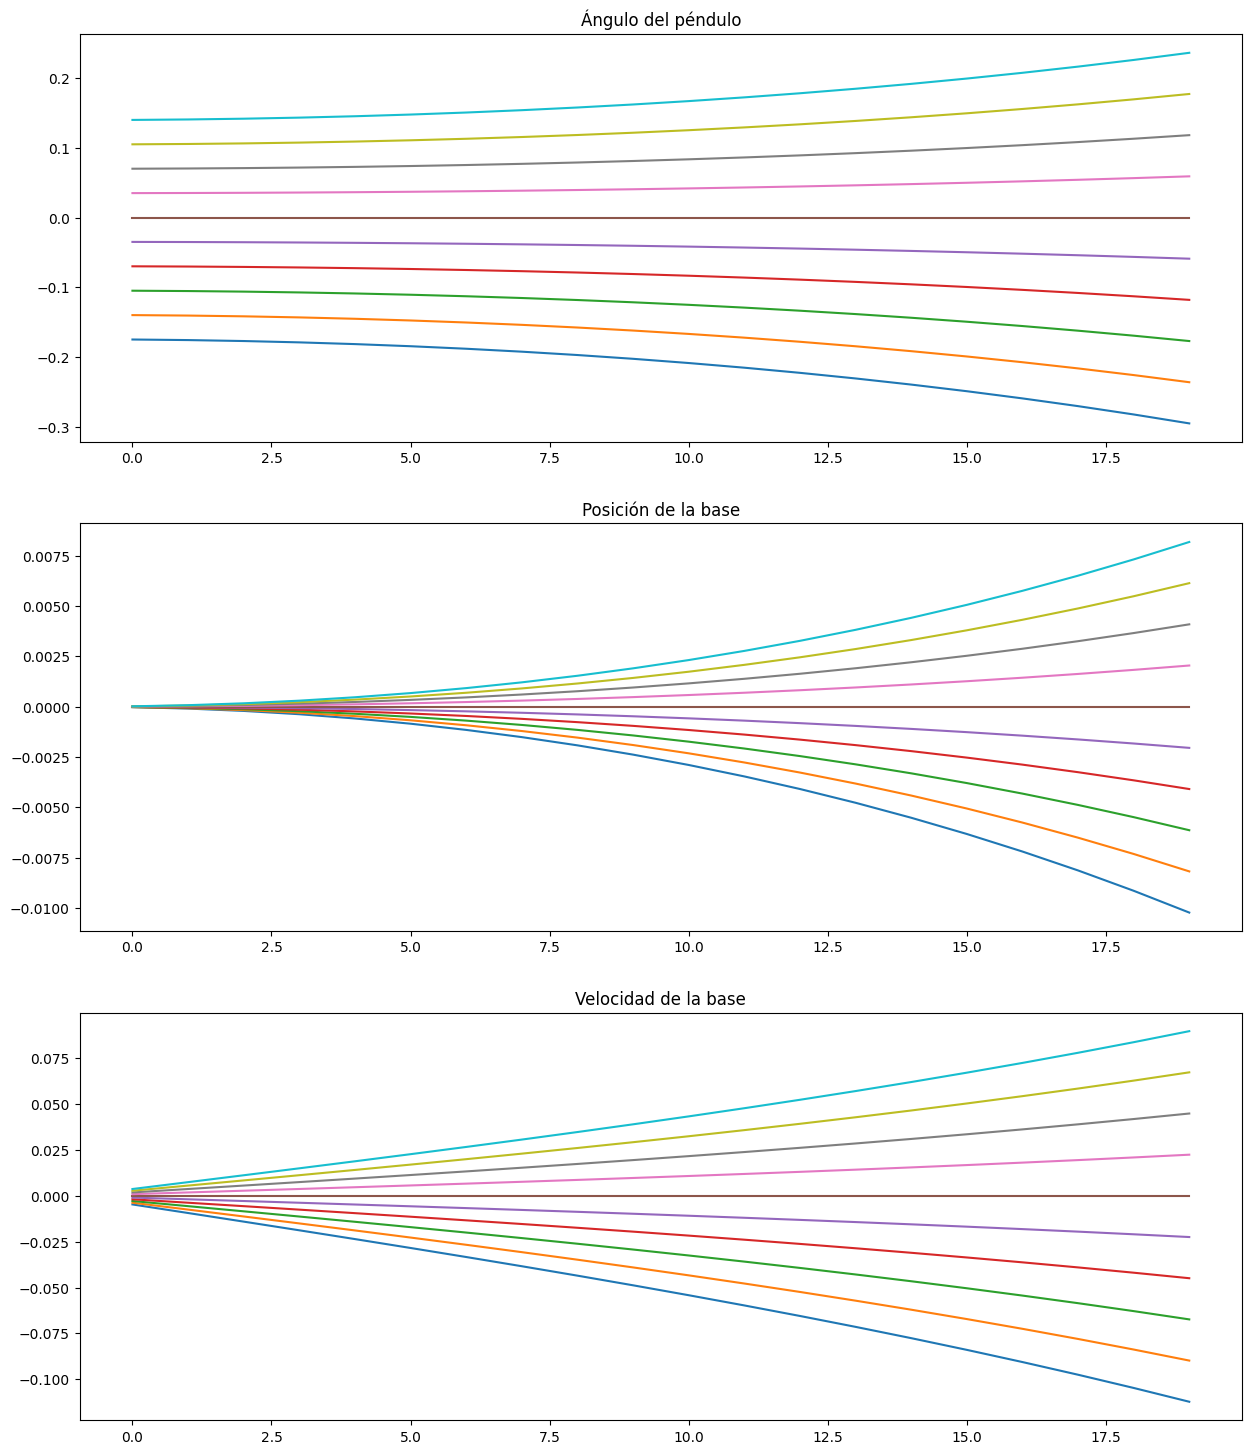

In [45]:
def plot_progress(ang,pos,vel):
    font = {'family': 'monospace','color':  '#39393d','weight': 'light','size': 24,}
    fig = plt.figure(figsize=(15,18), facecolor="white")
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    ax1.set_title("Ángulo del péndulo")
    ax2.set_title("Posición de la base")
    ax3.set_title("Velocidad de la base")
    t = np.arange(n)
    for i in range(s):
        ax1.plot(t,ang[i])
        ax2.plot(t,pos[i])
        ax3.plot(t,vel[i])

    plt.show()

plot_progress(angle_data,position_data,velocity_data)

Se prueban los diferentes controladores y sus resultados.

In [48]:
def nelder_mead(x0):
    res = minimize(cost_function, x0, method='nelder-mead',options={'xtol': 1e-8, 'disp': True})
    return res
plot_bool = False
result = nelder_mead(coefficients)

Optimization terminated successfully.
         Current function value: 1803.272112
         Iterations: 1
         Function evaluations: 6


/var/folders/5d/171tq19d2dq_g4s2h4dxnqf40000gn/T/ipykernel_59709/4279135689.py:2: OptimizeWarning: Unknown solver options: xtol
  res = minimize(cost_function, x0, method='nelder-mead',options={'xtol': 1e-8, 'disp': True})


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1803.2721122986125
             x: [ 1.000e-03 -1.050e-03  1.000e-03 -1.000e-03  1.000e-03]
           nit: 1
          nfev: 6
 final_simplex: (array([[ 1.000e-03, -1.050e-03, ..., -1.000e-03,
                         1.000e-03],
                       [ 1.000e-03, -1.000e-03, ..., -1.050e-03,
                         1.000e-03],
                       ...,
                       [ 1.000e-03, -1.000e-03, ..., -1.000e-03,
                         1.000e-03],
                       [ 1.050e-03, -1.000e-03, ..., -1.000e-03,
                         1.000e-03]]), array([ 1.803e+03,  1.803e+03,  1.803e+03,  1.803e+03,
                        1.803e+03,  1.803e+03]))


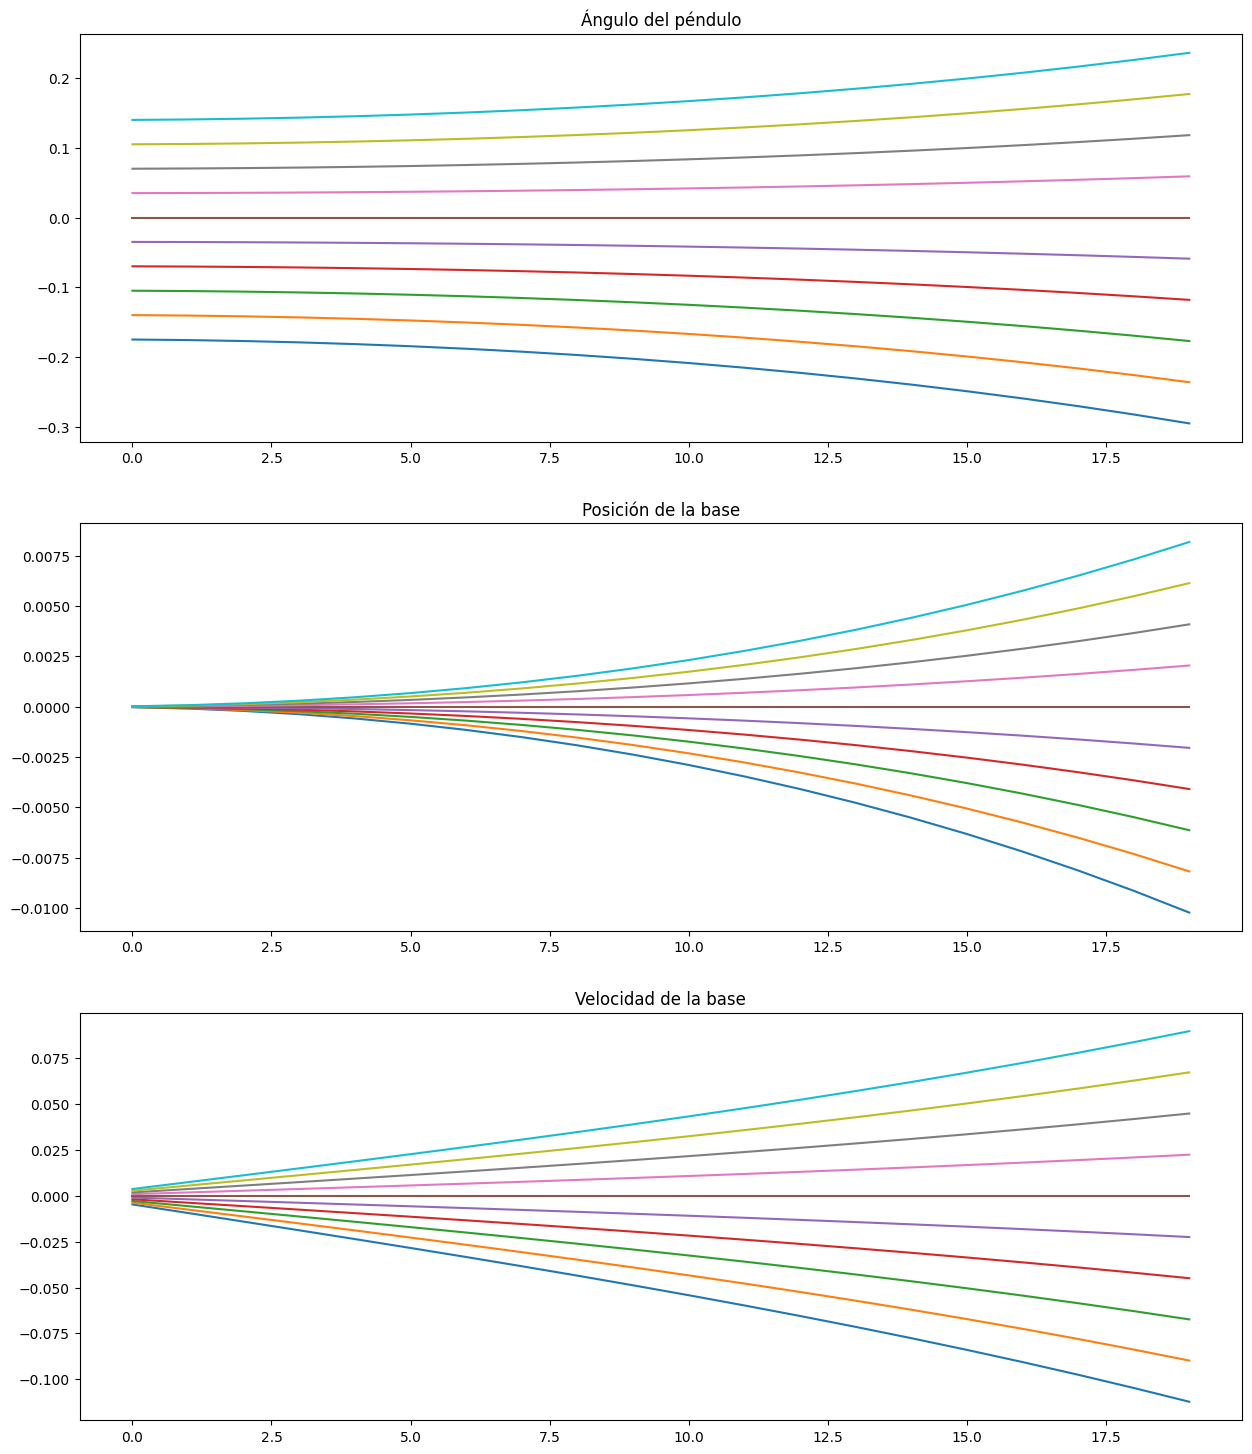

In [49]:
plot_bool = True
print(result)
angle_data, position_data, velocity_data = cost_function(result.x)
plot_progress(angle_data,position_data,velocity_data)